In [ ]:
# Import dependencies
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Read in the cardiovascular dataset from Google Sheets
cvd_df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSDchXr1EhgCSsxlxJ3lWPhh1kT5EJS3yv4DJ2YLeMIC3y4uq-Pp4EQknrs9zAiaI3ulne2Jyi6gR6G/pub?gid=602879552&single=true&output=csv")
cvd_df.head()

,general_health,checkup,exercise,heart_disease,skin_cancer,other_cancer,depression,diabetes,arthritis,sex,age_category,height_cm,weight_kg,bmi,smoking_history,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150,32.66,14.54,Yes,0,30,16,12
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165,77.11,28.29,No,0,30,0,4
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163,88.45,33.47,No,4,12,3,16
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180,93.44,28.73,No,0,30,30,8
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191,88.45,24.37,Yes,0,8,4,0


# Data Preprocessing

In [ ]:
# Check datatypes
cvd_df.dtypes

general_health                   object
checkup                          object
exercise                         object
heart_disease                    object
skin_cancer                      object
other_cancer                     object
depression                       object
diabetes                         object
arthritis                        object
sex                              object
age_category                     object
height_cm                         int64
weight_kg                       float64
bmi                             float64
smoking_history                  object
alcohol_consumption               int64
fruit_consumption                 int64
green_vegetables_consumption      int64
friedpotato_consumption           int64
dtype: object

In [ ]:
# Define categorical columns for encoding and numeric columns for scaling
categorical_cols = cvd_df.dtypes[cvd_df.dtypes == 'object'].index.tolist()

numeric_cols = cvd_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
# Check value counts of target variable
cvd_df['heart_disease'].value_counts()

No     275231
Yes     24081
Name: heart_disease, dtype: int64

The proportion of positive instances of heart disease ('Yes') to negative instances ('No') is heavily imbalanced. Initial testing revealed that this would result in a model that can accurately predict if a patient does not have heart diease, but is not able to accurately predict if a person does have disease. For this reason, we have decided to cut down the majority class, in this instance the 'No' category, to make the classes more balanced.

We have chosen to remove all datapoints that lay outside of 1 standard deviation from the mean of the data.

In [ ]:
# Calculate mean and standard deviation for numeric columns
means = cvd_df[numeric_cols].mean()
stds = cvd_df[numeric_cols].std()

# Define the number of standard deviations for the threshold
threshold_std = 1

# Identify outliers for numeric columns based on standard deviations
outliers = ((cvd_df[numeric_cols] - means).abs() > threshold_std * stds).any(axis=1)

# Filter rows where 'heart_disease' is 'No' and not an outlier
filtered_rows = (~outliers) | (cvd_df['heart_disease'] == 'Yes')

# Create the filtered DataFrame
cvd_df_filtered = cvd_df[filtered_rows]

In [ ]:
# Re-check value counts of target variable
cvd_df_filtered['heart_disease'].value_counts()

No     55566
Yes    24081
Name: heart_disease, dtype: int64

The classes in the target variable are now significantly closer to being balanced than previously.

In [ ]:
# Encode categorical columns using get_dummies
encoded_df = pd.get_dummies(cvd_df_filtered, columns=categorical_cols, drop_first=False)
encoded_df.head()

,height_cm,weight_kg,bmi,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,general_health_Excellent,general_health_Fair,general_health_Good,...,age_category_45-49,age_category_50-54,age_category_55-59,age_category_60-64,age_category_65-69,age_category_70-74,age_category_75-79,age_category_80+,smoking_history_No,smoking_history_Yes
1,165,77.11,28.29,0,30,0,4,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,180,93.44,28.73,0,30,30,8,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6,175,69.85,22.74,0,16,8,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
8,163,72.57,27.46,0,12,12,4,0,1,0,...,0,0,0,0,1,0,0,0,0,1
9,163,91.63,34.67,0,12,12,1,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
# Scale numerical columns using StandardScaler
scaler = StandardScaler()
encoded_df[numeric_cols] = scaler.fit_transform(encoded_df[numeric_cols])
encoded_df.head()

,height_cm,weight_kg,bmi,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,general_health_Excellent,general_health_Fair,general_health_Good,...,age_category_45-49,age_category_50-54,age_category_55-59,age_category_60-64,age_category_65-69,age_category_70-74,age_category_75-79,age_category_80+,smoking_history_No,smoking_history_Yes
1,-0.832260,-0.393566,-0.000590,-0.556508,0.413674,-1.250370,-0.166917,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1.184427,0.704890,0.095604,-0.556508,0.413674,1.515171,0.547281,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6,0.512198,-0.881918,-1.213951,-0.556508,-0.472114,-0.512893,-0.881115,0,1,0,...,0,0,0,1,0,0,0,0,0,1
8,-1.101152,-0.698954,-0.182048,-0.556508,-0.725196,-0.144154,-0.166917,0,1,0,...,0,0,0,0,1,0,0,0,0,1
9,-1.101152,0.583139,1.394228,-0.556508,-0.725196,-0.144154,-0.702566,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
# Assign the target variable 'heart_disease' to y
y = encoded_df['heart_disease_Yes']

# Assign the remaining columns (features) to X
X = encoded_df.drop(columns=['heart_disease_Yes', 'heart_disease_No'])

In [ ]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [ ]:
# Checking the value counts of the y variable
y_train.value_counts()

0    41653
1    18082
Name: heart_disease_Yes, dtype: int64

In [ ]:
# Fit a random over sampler model to the training data to balance out the classes fully
ROS = RandomOverSampler(random_state=78)
X_train_resampled, y_train_resampled = ROS.fit_resample(X_train, y_train)

In [ ]:
# Re-check the value counts to ensure oversampling has worked
y_train_resampled.value_counts()

1    41653
0    41653
Name: heart_disease_Yes, dtype: int64

# Model 1: Logistic Regression

Logistic regression is a statistical method for binary classification.
Instead of fitting a straight line or hyperplane, the logistic regression model uses the logistic function to squeeze the output of a linear equation between 0 and 1.

The solver used to optimize the parameters of the logistic regression model was 'saga' which is better suited for datasets with a large number of features.

In [ ]:
# Create a Logistic Regression Model
classifier = LogisticRegression(solver='saga', random_state=78)
classifier

LogisticRegression(random_state=78, solver='saga')

In [ ]:
# Train the data
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=78, solver='saga')

As mentioned previously the data was split into testing and training, then trained on the Logistic Regression Model using fit().


In [ ]:
# Score the model
print(f"Training Data Score: {lr_model.score(X_train, y_train)}")
print(f"Testing Data Score: {lr_model.score(X_test, y_test)}")

Training Data Score: 0.8134594458859965
Testing Data Score: 0.8164925672961029


The model calculated the following scores:

Training Data Score: 81.3% & Testing Data Score: 81.6%

Suggesting a high prediction of success for both testing and training data and overall a positive result. However the nature of the model is to successfully predict the likelyhood of someone having CVD, therefore these reults would suggest that just under 20% of the testing data would inaccurately predict the correct outcome.

In [ ]:
predictions = lr_model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
...,...,...
19907,0,0
19908,1,1
19909,1,1
19910,0,0


Calculate the Accuracy

In [ ]:
# Calculate the Accuracy Score  IMPORT
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

y_predictions = lr_model.predict(X_test)

In [ ]:
# Display the accuracy score for the test dataset.
accuracy_score(y_test, predictions)

0.8164925672961029

The accuaracy of the unoptimised model was 81.6%

Create Confusion Matrix

In [ ]:
# Display Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[12596,  1317],
       [ 2337,  3662]])

The confusion matrix calculates how many predictions are correct and incorrect
The matrix predicted the True positives, those who do not have heart disease as 12,596 and the True Negatives, those who did have heart disease as 3,662,

However, the matrix also shows 2337 false positives where those who had CVD would have been predict as not having it and 1317 trus positive, those who did not have CVD would be predicted as they did .

However in context the model shows a high level of predicting those who dont have CVD which is a great starting point, however could be due to the imbalanced original data set, which had higher number of applicanits without Heart Disease

Classification Report

In [ ]:
# Classifictaion Report
target_names = ["no heart disease", "has heart disease"]
print(classification_report(y_test, predictions, target_names=target_names))

                   precision    recall  f1-score   support

 no heart disease       0.84      0.91      0.87     13913
has heart disease       0.74      0.61      0.67      5999

         accuracy                           0.82     19912
        macro avg       0.79      0.76      0.77     19912
     weighted avg       0.81      0.82      0.81     19912



The Classification report is used to measure the quality of the prediction

**Precision** is the number of true positives divided by the number of true positives plus the number of false positives, i.e a high precision indicates a low false positive.
In this case the precison for No heart disease was 84% and 74% for has heart disease, which suggests there is higher chance of accuracy when predicting candidates who dont have heart diesaee than if they do.

**Recall** shows the true positive rate.
Those correctly identified as having heart disease shows a recall of 61% which is low in comprison to those who dont, with a high reacll of 91%

**Accuracy** shows how often the model is correct.
The overall accuracy of the model was 82% which is 'less than 1% higher than the unoptimised model.





Plot Logistic Regression Graph


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


<Axes: xlabel='heart_disease_Yes', ylabel='heart_disease_No'>

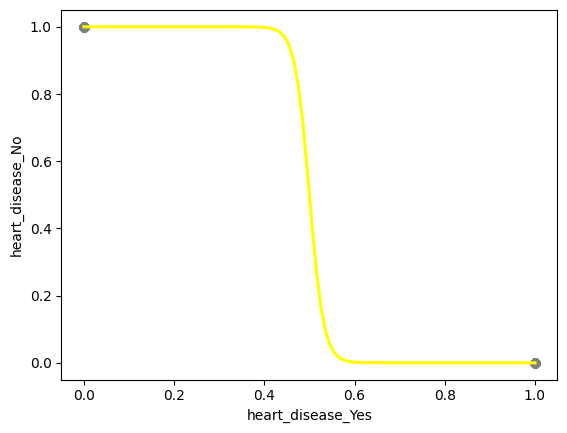

In [ ]:
import seaborn as sns

#define the predictor variable and the response variable
x = encoded_df['heart_disease_Yes']
y = encoded_df['heart_disease_No']

#plot logistic regression curve
sns.regplot(x=x, y=y, data=encoded_df, logistic=True, ci=None, scatter_kws={'color': 'gray'}, line_kws={'color': 'yellow'})

# Model 2: Support Vector Machine

In [ ]:
# Initialise model and fit to the training data
model = SVC(kernel='linear')
model.fit(X_train_resampled, y_train_resampled)

SVC(kernel='linear')

In [ ]:
# Validate with the test data
model.score(X_test, y_test)

0.7871132985134592

In [ ]:
# Save model's predicitons for the test data
training_predictions = model.predict(X_test)

In [ ]:
# Create a confusion matrix
training_matrix = confusion_matrix(y_test, training_predictions)
pd.DataFrame(training_matrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

,Predicted 0,Predicted 1
Actual 0,10845,3068
Actual 1,1171,4828


In [ ]:
# Target prediciton categories
target_names = ["No Heart Disease", "Heart Disease"]
# Print a classification report
print(classification_report(y_test, training_predictions,
                            target_names=target_names))

                  precision    recall  f1-score   support

No Heart Disease       0.90      0.78      0.84     13913
   Heart Disease       0.61      0.80      0.69      5999

        accuracy                           0.79     19912
       macro avg       0.76      0.79      0.77     19912
    weighted avg       0.81      0.79      0.79     19912



# Model 3: Decision Tree

# Model 4: Random Forest

# Model 5: Neural Network